Install requeriments

In [0]:
!pip install pydub

!apt install sox

!pip install tflearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 7 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,715 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrwb0 amd64 0.1.3-2.1 [45.8 kB]
Get:3 http://archive.ubuntu.com/ubunt

Download lapsbm dataset for test

In [0]:
import os 
base = 'es'
# download dataset https://www.openslr.org/61/
!wget -c -q --show-progress -O ./es.zip https://www.openslr.org/resources/61/es_ar_male.zip
!mkdir es
os.chdir('es') 
!unzip ../es.zip

os.chdir('..')
!ls

./es.zip            100%[===================>] 526.02M  13.2MB/s    in 36s     
Archive:  ../es.zip
  inflating: arm_00610_00021565457.wav  
  inflating: arm_00610_00072700102.wav  
  inflating: arm_00610_00073376588.wav  
  inflating: arm_00610_00073732425.wav  
  inflating: arm_00610_00080474855.wav  
  inflating: arm_00610_00085090557.wav  
  inflating: arm_00610_00099003036.wav  
  inflating: arm_00610_00107707160.wav  
  inflating: arm_00610_00118386283.wav  
  inflating: arm_00610_00122244953.wav  
  inflating: arm_00610_00125219040.wav  
  inflating: arm_00610_00131121944.wav  
  inflating: arm_00610_00135590686.wav  
  inflating: arm_00610_00161996245.wav  
  inflating: arm_00610_00180010310.wav  
  inflating: arm_00610_00267700622.wav  
  inflating: arm_00610_00281575425.wav  
  inflating: arm_00610_00282879796.wav  
  inflating: arm_00610_00307222262.wav  
  inflating: arm_00610_00339440734.wav  
  inflating: arm_00610_00340277597.wav  
  inflating: arm_00610_00383264955.wav 

In [0]:
from pydub import AudioSegment as audio
import scipy.io.wavfile

def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms
 
    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0  # ms
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold:
        trim_ms += chunk_size
 
    return trim_ms

def remove_silence(file_path,out_aux='aux_silence.wav'):
    sound = audio.from_wav(file_path)
    start_trim = detect_leading_silence(sound)
    end_trim = detect_leading_silence(sound.reverse())
    duration = len(sound)
    trimmed_sound = sound[start_trim:duration-end_trim]
    trimmed_sound.export(out_aux, format="wav")

In [0]:
!rm -rf   es-preprocessed
!mkdir es-preprocessed


import librosa
import numpy as np

#adiciona todos os áudio de um mesmo locutor em um unico arquivo wav, necessário pois os áudios das lapsbm possuem tamanho inferior a 5 segundos.
waves = []
dirs =  os.listdir(base)
dirs.sort()
output = 'es-preprocessed'
ant_file = dirs[1].split('_')[1]
wav = []
for file in dirs:
  if os.path.splitext(file)[1] == '.wav':
    loc = file.split('_')[1]
    if loc == ant_file:
        remove_silence(os.path.join(base,file))
        #os.system('sox '+os.path.join(base,file)+' aux_silence.wav silence -l 1 0.1 1% -1 2.0 1% ' )# remover silencio inicial
        wav = wav+list((librosa.load('aux_silence.wav',sr=44100)[0]))
    else:
        librosa.output.write_wav(os.path.join(output,ant_file+'.wav'),np.array(wav),sr=44100)
        remove_silence(os.path.join(base,file))# remover silencio inicial e final
        wav = list((librosa.load('aux_silence.wav',sr=44100)[0]))
        print(loc)
    ant_file = loc    
    

librosa.output.write_wav(os.path.join(output,ant_file+'.wav'),np.array(wav),sr=44100)

        
      

01523
02484
03397
04310
05223
06136
07049
07508
08421
08784
09334
09697


In [0]:
from pydub import AudioSegment as audio
import scipy.io.wavfile
base = 'es-preprocessed'
waves = []
dirs =  os.listdir(base)
dirs.sort()
for file in dirs:
  if os.path.splitext(file)[1] == '.wav':
    loc = file.split('.')[0]
    waves.append([audio.from_wav(os.path.join(base,file)),loc])






In [0]:
waves = waves

amostras_cadastradas = [] #armazenara as amostras de cada locutor ( uma cada locutor)
amostras_novas= [] # armazena as amostras de teste, serão varias por locutor a ideia é que com as amostras cadastradas seja possivel identificar o locutor dessas novas amostras
flag = 0 
#segmenta todos os áudios em 5 segundos.
print(len(waves))
for wave in waves: 
  

  begin = 0
  end = 5
  flag = 0
  
  
  while (end*1) < int(wave[0].duration_seconds):
    try:
        
      segment = wave[0][begin*1000:end*1000]
      # o áudio é exportado pois é necessario ler e extrair o mfcc com a biblioteca librosa( mesma utilizada no treinamento do modelo)  
      segment.export('aux' + '.wav', 'wav')
      y, sr = librosa.load('aux.wav')   
      if(flag == 0):
        amostras_cadastradas.append([librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13),int(wave[1])])
        flag =1
      else:
        amostras_novas.append([librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13),int(wave[1])])
      
      
      os.system('rm aux.wav')
      begin = begin + 5
      end = end + 5
      
    except:
      print('erro')
      begin = begin + 5
      end = end + 5


print('Numero de locutores:', len(amostras_cadastradas), ' Numero de novas amostras a serem testadas:', len(amostras_novas))



13
Numero de locutores: 13  Numero de novas amostras a serem testadas: 986


In [0]:
import tflearn

#Download Weights
!wget -O ./saver.zip https://www.dropbox.com/s/b19xt2wu3th9p36/Save-Models-Speaker-Diarization.zip?dl=0
!unzip saver.zip

#Create model for restore
encoder = tflearn.input_data(shape=[None, 13,int(216)])
encoder = tflearn.dropout(encoder,0.9) #10 % drop - 90% -> 80
encoder = tflearn.dropout(encoder,0.2)# 80 % drop
encoder = tflearn.fully_connected(encoder, 40,activation='crelu')
decoder = tflearn.fully_connected(encoder, int(572), activation='linear')
net = tflearn.regression(decoder, optimizer='adam', learning_rate=0.0007,loss='mean_square', metric=None)#categorical_crossentropy
model = tflearn.DNN(net, tensorboard_verbose=0,tensorboard_dir='tflearn_logs')


model.load('./Save-Models/Model3-Best.tflearn')

encoding_model = tflearn.DNN(encoder, session=model.session)# used for extract embedding in encoder layer








--2019-12-26 17:38:20--  https://www.dropbox.com/s/b19xt2wu3th9p36/Save-Models-Speaker-Diarization.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/b19xt2wu3th9p36/Save-Models-Speaker-Diarization.zip [following]
--2019-12-26 17:38:21--  https://www.dropbox.com/s/raw/b19xt2wu3th9p36/Save-Models-Speaker-Diarization.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca95a7642d4c8aa55140dfb3c59.dl.dropboxusercontent.com/cd/0/inline/Au_8DjDd4GYL9phucmiyIXkiWqoNrcO6NU0ffJUwcWS4JkvFL4MrT6lqawo1CDbQRgzaNXKRq9cQ7BkKOZDt5ISdcDkkK5MKU0EbGX-DVLicLA/file# [following]
--2019-12-26 17:38:21--  https://uca95a7642d4c8aa55140dfb3c59.dl.dropboxusercontent.com/cd/0/inline/Au_8DjDd4GYL9phucmiyIXkiWqoNrcO6NU0ffJUwcWS4JkvFL4MrT6l

In [0]:
# extract embeddings
embedding_cadastrado = []
embedding_novo = [] 
for amostra in  amostras_cadastradas:
  embedding_cadastrado.append([encoding_model.predict([amostra[0]])[0],amostra[1]]) # estrutura [embedding,id do locutor]
  
for amostra in  amostras_novas:
  embedding_novo.append([encoding_model.predict([amostra[0]])[0],amostra[1]]) 
  
  
  
  

In [0]:
import math
import numpy as np 
acertou = 0 
posI = 0

for j in range(len(embedding_novo)):
  #print(j,' de ',len(embedding_novo))
  menordist = math.inf
  i =0
                
  while i < len(embedding_cadastrado):
    distancia = np.sqrt(sum([(xi-yi)**2 for xi,yi in zip(embedding_novo[j][0],embedding_cadastrado[i][0])]))#distancia euclediana
    if distancia <  menordist:
      menordist = distancia
      posI= i
    i=i+1  
            
            
  if(embedding_cadastrado[posI][1] == embedding_novo[j][1]):
    acertou = acertou +1

print('numero de acertos:', acertou)               

           
          


numero de acertos: 730


In [0]:
acc  = acertou/len(embedding_novo)
print("Acuracia: ",acc)
print('De ',len(embedding_novo), " classificou corretamente ", acertou, 'amostras considerando ', len(embedding_cadastrado),'locutores cadastrados')

Acuracia:  0.7403651115618661
De  986  classificou corretamente  730 amostras considerando  13 locutores cadastrados


iniciando comparação
2
2 1.0
3
3 1.0
4
4 0.7943262411347518
5
5 0.8319559228650137
6
6 0.7785087719298246
7
7 0.8079847908745247
8
8 0.7380560131795717
9
9 0.7402985074626866
11
11 0.764277035236938
12
12 0.7381215469613259
13
13 0.7403651115618661


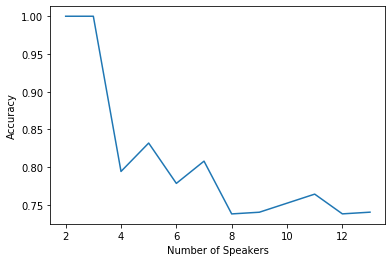

[2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13] [1.0, 1.0, 0.7943262411347518, 0.8319559228650137, 0.7785087719298246, 0.8079847908745247, 0.7380560131795717, 0.7402985074626866, 0.764277035236938, 0.7381215469613259, 0.7403651115618661]


In [0]:
print("iniciando comparação")
XLosc = []    
YAcc =[]
for d in range(2,14):
    if d == 10:
      continue
    V =[]
    X=[]
    locs_list=[]
    for b in range(d):
            X.append(embedding_cadastrado[b])
            locs_list.append(embedding_cadastrado[b][1])

    for i in embedding_novo:
        if i[1] in locs_list:
            V.append(i)
    

            
    print(d)
              



    acertou = 0
    tamanho = 0

                                        
            
    posI = 0

    for j in range(len(V)):
            
            menordist = math.inf
            i =0
                
            while i < len(X):
                    
                    distancia = np.sqrt(sum([(xi-yi)**2 for xi,yi in zip(V[j][0],X[i][0])]))
                    
                    if distancia <  menordist:
                        menordist = distancia
                        posI= i
                    i=i+1
            
            
            if(X[posI][1] == V[j][1]):
                    acertou = acertou +1
                    

           


    tamanho = len(V)    
    if tamanho != 0:    
        acc  = acertou/tamanho
        XLosc.append(d)
        YAcc.append(acc)
        print(d,acc)


import matplotlib.pyplot as plt


plt.plot(XLosc,YAcc)
plt.xlabel("Number of Speakers")
plt.ylabel("Accuracy")
plt.savefig('grafico.png')
plt.show()    
print(XLosc,YAcc)